In [20]:
# Importations
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from datetime import datetime
from skimage import *
from skimage.measure import profile_line
from skimage.metrics import structural_similarity as ssim
from skimage.feature import match_template
from skimage.measure import profile_line
from scipy.ndimage import map_coordinates
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import xml.etree.ElementTree as ET
import tkinter as tk
from tkinter import filedialog

In [21]:
directory = "../Images"

files = os.listdir(directory)

list_image_to_process = []

for file in files:
    imgs = os.listdir(directory + "/" + file)
    #print(imgs)
    for img in imgs:
        list_image_to_process.append(directory + "/" + file + "/" + img) if img.endswith(".tif") and "16" in img else None

print(list_image_to_process)
print(len(list_image_to_process))

['../Images/20221104_Controle_Periodique_OUN/16-200-IQI_TrouFondPlat_04-11-2022.tif', '../Images/20221104_Controle_Periodique_OUN/16-IQI_TrouFondPlat_04-11-2022.tif', '../Images/20230502_Controle_Periodique_DAN/16-200-IQI_TrouFondPlat_02-05-2023.tif', '../Images/20230502_Controle_Periodique_DAN/16-IQI_TrouFondPlat_02-05-2023.tif', '../Images/20240201_Controle_Periodique_DAN/16-200-IQI_TrouFondPlat_01-02-2024.tif', '../Images/20240201_Controle_Periodique_DAN/16-IQI_TrouFondPlat_01-02-2024.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_02-01-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_02-05-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-01-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-04-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-07-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_03-08-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_04-12-2023.tif', '../Images/Résolution3/16-200-IQI_TrouFondPlat_05-12-

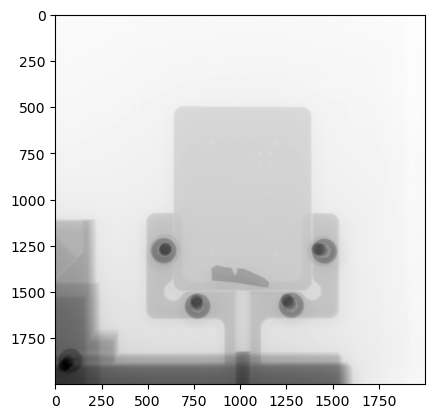

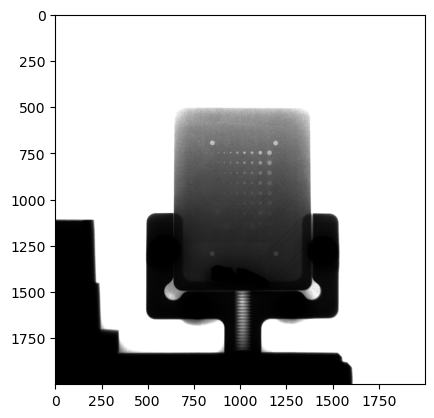

In [22]:
images = []
cropped_images = []
image_initial = []

i = 4   # 4 marche perefect
#marche: 1,2,3,5
#marche pas: 0,6
for path in list_image_to_process:
    # Charger l'image et changer le contraste
    image = mpimg.imread(path)
    # Adaptation 16bits -> 8bits
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image_initial.append(image)
    # Ajustement du contraste et luminosité
    brightness_factor = 1.17
    brightened_image = image * brightness_factor

    # S'assurer que les valeurs sont toujours dans l'intervalle [0, 1]
    brightened_image = np.clip(brightened_image, 0, 255)
    image_contraste = exposure.adjust_gamma(brightened_image,30)

    images.append(image_contraste)

        # Afficher l'image recadrée
plt.imshow(image_initial[1], cmap='gray')
        #plt.title(f'Image recadrée: {path}')
plt.show()
        # Afficher l'image recadrée
plt.imshow(images[1], cmap='gray')
        #plt.title(f'Image recadrée: {path}')
plt.show()

In [23]:
def load_image(image_path):
    """
    Charge une image en niveau de gris
    :param image_path: chemin de l'image
    :return: image en niveau de gris
    """
    image = mpimg.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def template_matching(template1_path, template2_path, image):
    """
    Trouver le meilleur match entre le template et l'image
    :param template1: template 1
    :param template2: template 2
    :param image: image
    :return: coordonnées du meilleur match
    """
    template1 = load_image(template1_path)
    template2 = load_image(template2_path)

    template1 =cv2.cvtColor(template1, cv2.COLOR_BGR2GRAY)
    template2 =cv2.cvtColor(template2, cv2.COLOR_BGR2GRAY)

    ################# Template 1 #####################
    liste_temp_match1 = []
    result = match_template(image, template1)

    # Trouver l'emplacement maximal de la correspondance
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h, w = template1.shape
    """
    # Dessiner un rectangle autour de la zone correspondante
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title('Detected Template')
    plt.show()
    """
    # Croper l'image selon le template matching
    cropped_image1 = image[y:y+h, x:x+w]

    # Ajouter l'image croppée à la liste
    liste_temp_match1.append(cropped_image1)

    '''
    # Afficher l'image croppée pour vérification
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image1, cmap='gray')
    plt.title('Cropped Image 1')
    plt.show()
    '''

    ################## Template 2 ######################
    liste_temp_match2 = []
    # Appliquer le template matching
    result = match_template(cropped_image1, template2)

    # Trouver l'emplacement maximal de la correspondance
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h, w = template2.shape

    '''
    # Dessiner un rectangle autour de la zone correspondante
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(cropped_image1, cmap='gray')
    rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title('Detected Template')
    plt.show()
    '''
    # Croper l'image selon le template matching
    cropped_image2 = cropped_image1[y:y+h, x:x+w]

    # Ajouter l'image croppée à la liste
    liste_temp_match2.append(cropped_image2)

    # Afficher l'image croppée pour vérification
    '''
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_image2, cmap='gray')
    plt.title('Cropped Image 2')
    plt.show()
    '''
    return cropped_image2

TEMPLATE1_PATH = "template5.jpg"
TEMPLATE2_PATH = "template5bis.jpg"

In [24]:
def normalize_img(img):
    """
    Normaliser une image
    :param img: image à normaliser
    :return: image normalisée
    """
    min = np.min(img)
    max = np.max(img)

    normalized_image = (img - min) / (max - min) * 255
    normalized_image = np.uint8(normalized_image)
    # Supposons que  image soit stockée dans la variable "image"
    min_value = np.min(normalized_image)
    max_value = np.max(normalized_image)
    print(min_value)
    print(max_value)
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')
    plt.show()
    """
    return normalized_image

In [25]:
# Fonction pour extraire le centre de l'image
def extract_central_zone(img, p=0.2):
    h, w = img.shape[:2]
    start_row, end_row = 0, 50
    start_col, end_col = 400, 500
    center_img = img[start_row:end_row, start_col:end_col]
    return center_img

0
255


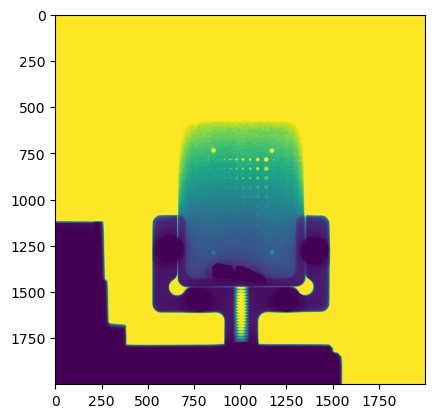

In [26]:
from PIL import Image
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt


# Open the image

image = images[29]
image_path = "image29.tif"
cropped_img = template_matching(TEMPLATE1_PATH, TEMPLATE2_PATH, image)
img_normalized = normalize_img(cropped_img)
# Convert the image to PIL Image object
pil_image = Image.fromarray(img_normalized)

# Convert the image to PNG format
png_image_path = image_path.replace(".tif", ".png")
pil_image.save(png_image_path, "PNG")

# Display the image
plt.imshow(pil_image)
plt.imshow(image)
pil_image.save("saved_image.png", "PNG")
plt.show()



# wavelet transform 

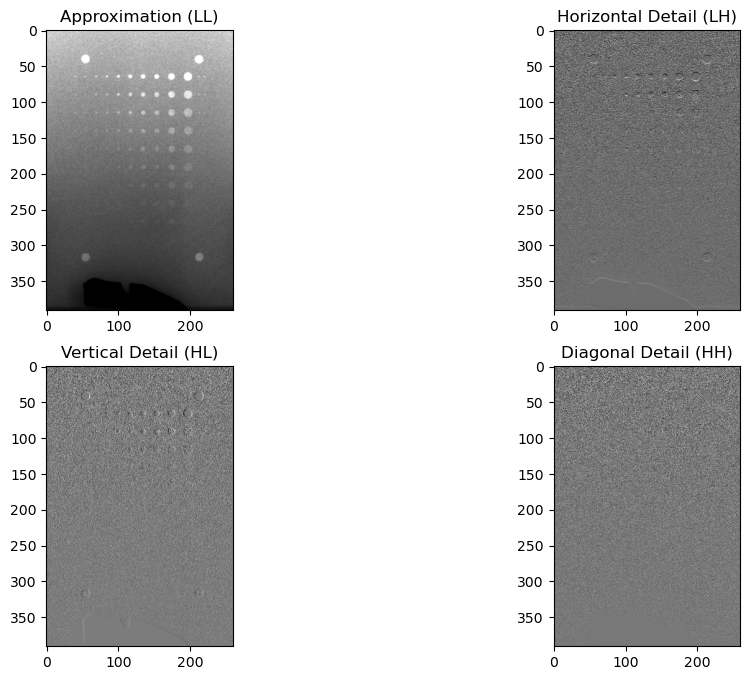

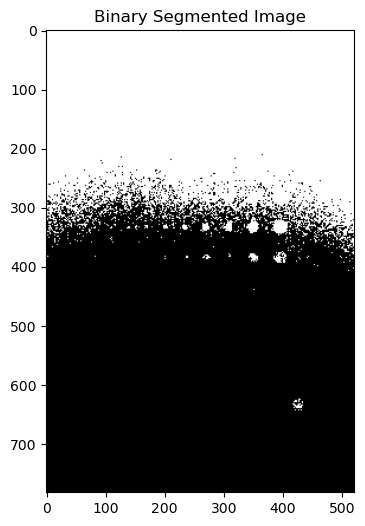

In [27]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load the image
image_path = 'image29.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply wavelet transform
coeffs2 = pywt.dwt2(image, 'haar')
LL, (LH, HL, HH) = coeffs2

# Display intermediate wavelet coefficient images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Approximation (LL)')
plt.imshow(LL, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Horizontal Detail (LH)')
plt.imshow(LH, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Vertical Detail (HL)')
plt.imshow(HL, cmap='gray')

plt.subplot(2, 2, 4)
plt.title('Diagonal Detail (HH)')
plt.imshow(HH, cmap='gray')

plt.show()

# Function to enhance wavelet coefficients
def enhance_coeffs(coeffs, threshold_value):
    # Apply soft thresholding
    coeffs_thresh = pywt.threshold(coeffs, threshold_value, mode='soft')
    # Enhance significant details by scaling the coefficients
    return coeffs_thresh * 1.5

# Adjust the threshold values for better segmentation
LH_thresh = enhance_coeffs(LH, 30)
HL_thresh = enhance_coeffs(HL, 30)
HH_thresh = pywt.threshold(HH, 20, mode='soft')  # Apply regular thresholding to HH

# Reconstruct the image using inverse wavelet transform
coeffs2_thresh = LL, (LH_thresh, HL_thresh, HH_thresh)
segmented_image = pywt.idwt2(coeffs2_thresh, 'haar')

# Apply binary thresholding to the segmented image
_, binary_image = cv2.threshold(segmented_image, 127, 255, cv2.THRESH_BINARY)


# Display the original, binary segmented, and morphologically closed images
plt.figure(figsize=(18, 6))
'''
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
'''
plt.subplot(1, 3, 2)
plt.title('Binary Segmented Image')
plt.imshow(binary_image, cmap='gray')

plt.show()


(-0.5, 259.5, 390.5, -0.5)

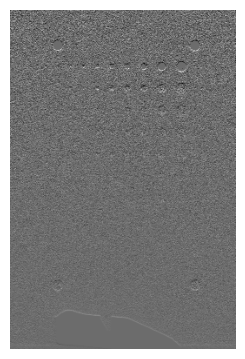

In [28]:
plt.subplot(1, 2, 2)
plt.imshow(LH, cmap='gray')
plt.axis('off')

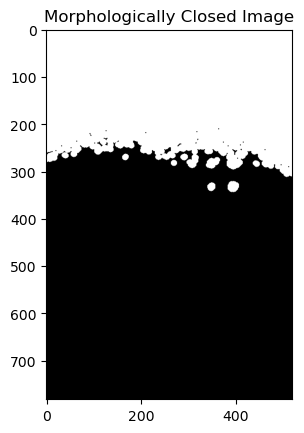

In [29]:
# Create a disk-shaped kernel with a radius of 5
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))

# Apply morphological closing with the disk-shaped kernel
closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

plt.title('Morphologically Closed Image')
plt.imshow(closed_image, cmap='gray')

plt.show()

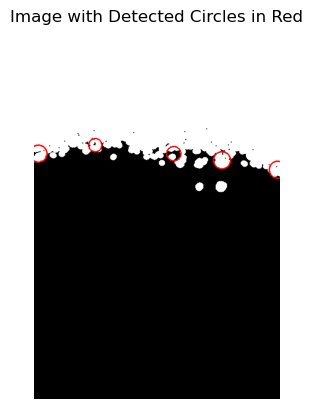

In [30]:
# Normalize the closed image to 0-255 range
closed_image = cv2.normalize(closed_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Detect circles in the closed image
circles = cv2.HoughCircles(closed_image, cv2.HOUGH_GRADIENT, dp=2, minDist=100, param1=20, param2=10, minRadius=13, maxRadius=19)

# Convert closed_image to color to draw red circles
closed_image_color = cv2.cvtColor(closed_image, cv2.COLOR_GRAY2BGR)

# Draw circles on the closed image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(closed_image_color, (x, y), r, (0, 0, 255), 2)  # Red color in BGR format

# Convert image back to RGB for displaying with Matplotlib
closed_image_color_rgb = cv2.cvtColor(closed_image_color, cv2.COLOR_BGR2RGB)

# Display the image with circles
plt.imshow(closed_image_color_rgb)
plt.title('Image with Detected Circles in Red')
plt.axis('off')  # Hide axis
plt.show()

# SOM model 

In [31]:
import numpy as np
import torch

class KohonenSOM:
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.weights = np.random.rand(x, y, input_len)

    def _neighborhood_function(self, c, sigma):
        d = 2 * np.pi * sigma * sigma
        ax = np.exp(-np.power(np.arange(self.x) - c[0], 2) / d)
        ay = np.exp(-np.power(np.arange(self.y) - c[1], 2) / d)
        return np.outer(ax, ay)

    def _learning_rate_decay(self, t, max_iter):
        return self.learning_rate * np.exp(-t / max_iter)

    def train(self, data, num_iterations):
        for t in range(num_iterations):
            rand_i = np.random.randint(len(data))
            vec = data[rand_i]
            bmu = self._find_bmu(vec)
            sigma = self.sigma * np.exp(-t / num_iterations)
            learning_rate = self._learning_rate_decay(t, num_iterations)
            neighborhood = self._neighborhood_function(bmu, sigma)
            for i in range(self.x):
                for j in range(self.y):
                    self.weights[i, j, :] += learning_rate * neighborhood[i, j] * (vec - self.weights[i, j, :])

    def _find_bmu(self, vec):
        diff = self.weights - vec
        dist = np.sqrt(np.sum(diff**2, axis=-1))
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)

    def map_vects(self, data):
        return np.array([self._find_bmu(vec) for vec in data])

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_normalized = normalize_img(image)
    return img_normalized

def segment_image(image, som, width, height):
    h, w = image.shape
    segmented_image = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            bmu = som._find_bmu(image[i, j])
            segmented_image[i, j] = bmu[0].item() * som.x + bmu[1].item()
    segmented_image = cv2.resize(segmented_image, (width, height), interpolation=cv2.INTER_NEAREST)
    return segmented_image

0
255


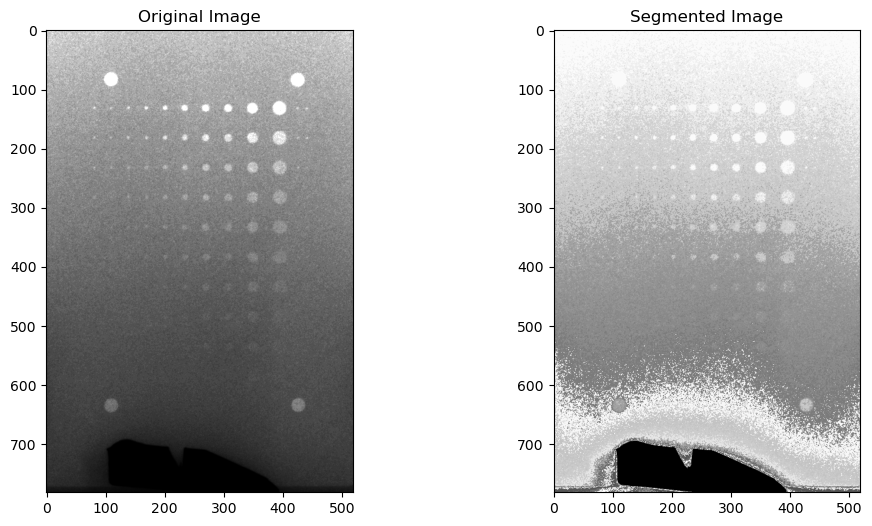

In [32]:
# Load and preprocess image
image_path = 'image29.png'
image = preprocess_image(image_path)
height, width = image.shape

# Initialize and train SOM
som = KohonenSOM(30, 30, 1, sigma=1.5, learning_rate=0.1)
flat_image = image.flatten().reshape(-1, 1)
som.train(flat_image, num_iterations=1000)

# Segment image using SOM
segmented_image = segment_image(image, som, width, height)

# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(segmented_image, cmap='gray')

plt.show()

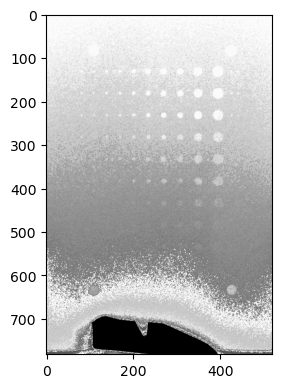

In [33]:
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')

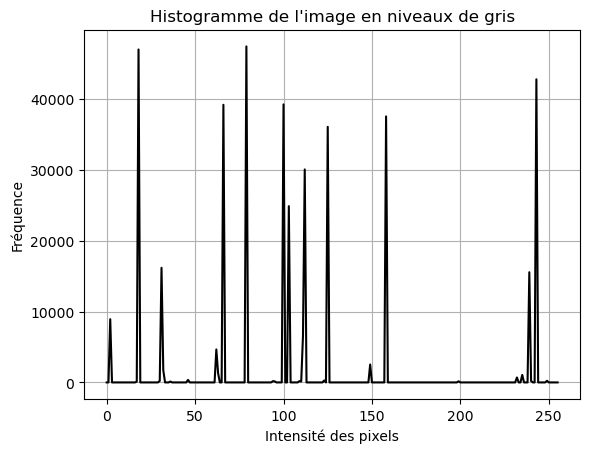

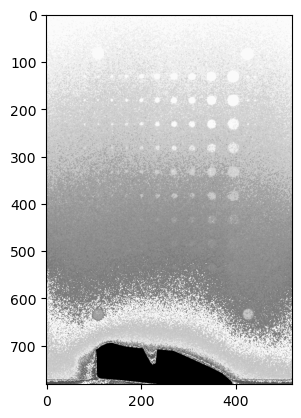

In [34]:
if image is None:
    print("Erreur lors du chargement de l'image.")
else:
    # Convert segmented_image to uint8 format
    segmented_image_uint8 = segmented_image.astype(np.uint8)

    # Calculer l'histogramme
    histogram = cv2.calcHist([segmented_image_uint8], [0], None, [256], [0, 256])

    # Tracer l'histogramme
    plt.plot(histogram, color='black')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Fréquence')
    plt.title('Histogramme de l\'image en niveaux de gris')
    plt.grid(True)
    plt.show()
    plt.imshow(segmented_image, cmap='gray')

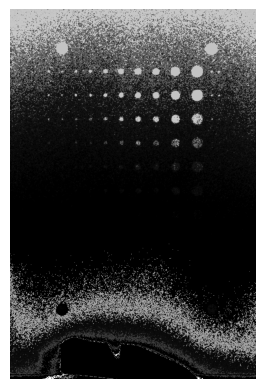

In [60]:
brightness_factor = 0.8
brightened_image = segmented_image * brightness_factor

# S'assurer que les valeurs sont toujours dans l'intervalle [0, 1]
brightened_image = np.clip(segmented_image, 0, 255)
image_contraste = exposure.adjust_gamma(segmented_image,20)

# Afficher l'image recadrée
plt.imshow(image_contraste, cmap='gray')
#plt.title(f'Image recadrée: {path}')
plt.axis('off')
plt.show()


# Kmeans

# watershed

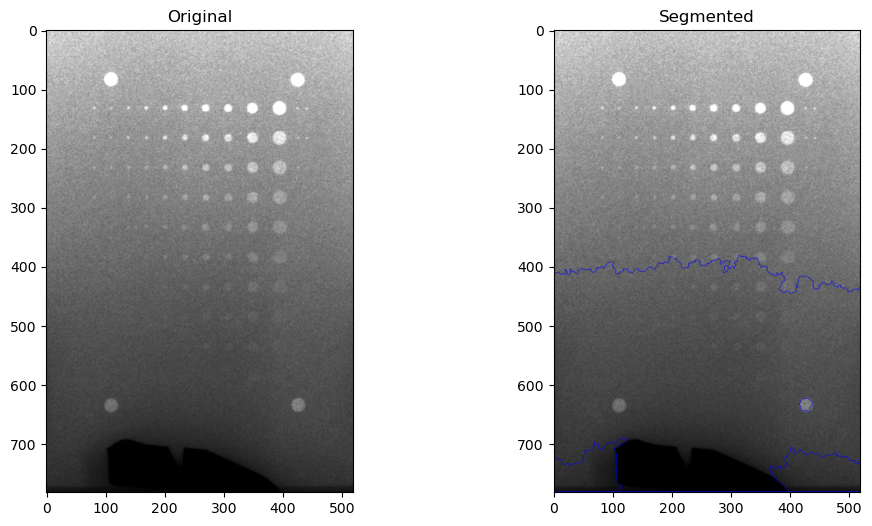

In [35]:
def watershed_segmentation(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)

    markers = markers + 1

    markers[unknown == 255] = 0

    # Apply the watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark boundaries with red

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)), plt.title('Original')
    plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Segmented')
    plt.show()

# Replace 'path_to_image.jpg' with your image file path
watershed_segmentation('image29.png')

# Mean shift clustering


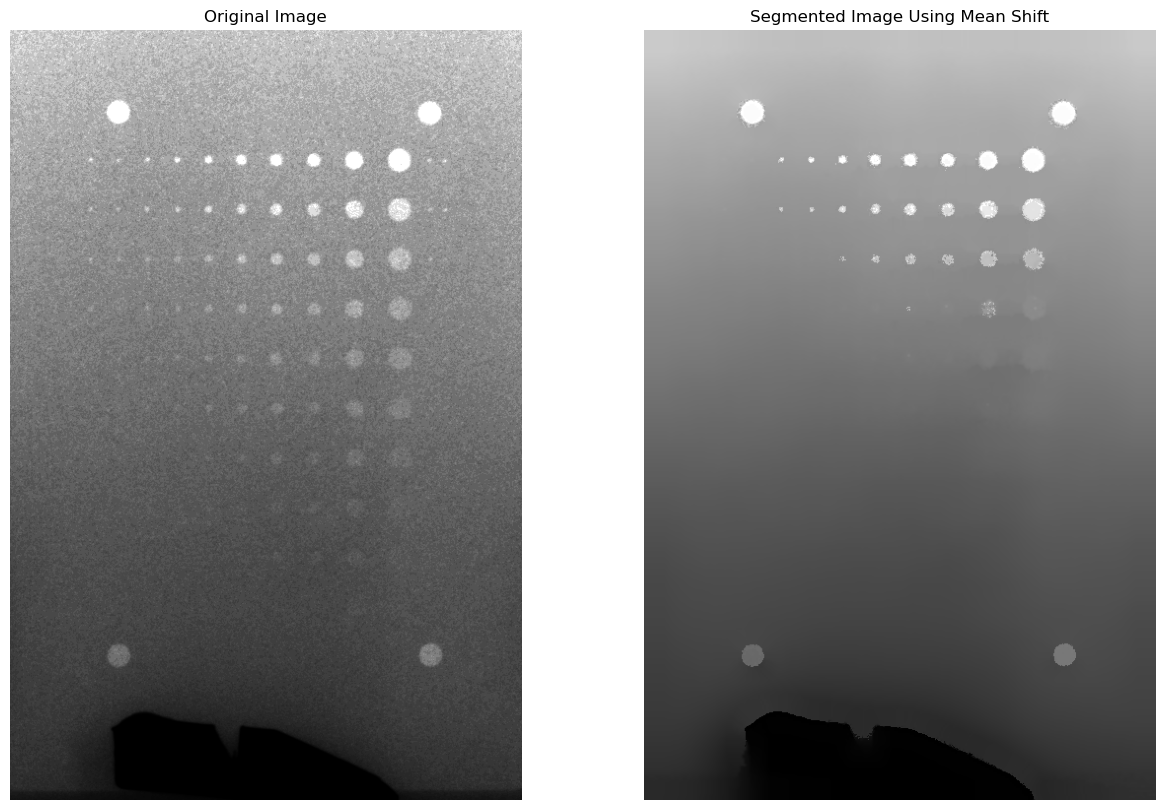

In [36]:
def mean_shift_segmentation(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert from BGR to RGB for displaying
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define the criteria for stopping the algorithm
    # (type, max number of iterations, accuracy)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.2)

    # Apply the Mean Shift algorithm to find the clusters
    segmented_image = cv2.pyrMeanShiftFiltering(original_image, sp=20, sr=40, maxLevel=1, termcrit=criteria)

    # Displaying the original and segmented images
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Segmented Image Using Mean Shift')
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()

    return segmented_image
# Provide the path to your image file
segmented_image_8 = mean_shift_segmentation('image29.png')

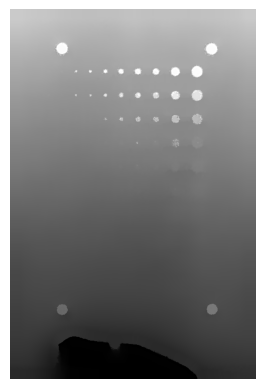

In [46]:

plt.imshow(segmented_image_8, cmap='gray')
plt.axis('off')
plt.show()

## image segmentation with entropy

In [38]:
if segmented_image_8 is None or segmented_image_8.size == 0:
    print("Image is empty")
else:
    print("Image is loaded correctly")

print("Data type of image:", segmented_image_8.dtype)
print("Shape of image:", segmented_image_8.shape)

# Convert image to grayscale
gray_image = cv2.cvtColor(segmented_image_8, cv2.COLOR_RGB2GRAY)

Image is loaded correctly
Data type of image: uint8
Shape of image: (782, 519, 3)


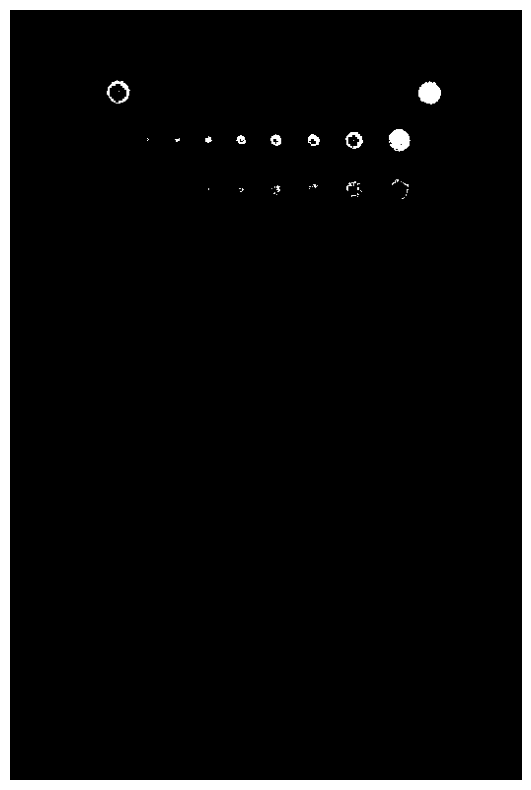

In [61]:
from cv2 import getStructuringElement


def entropy(signal):
    """Calcul de l'entropie d'un signal."""
    hist, _ = np.histogram(signal, bins=256, range=(0, 255))
    hist = hist / (float(np.sum(hist)) + 1e-8)
    hist = hist[hist != 0]
    return -np.sum(hist * np.log2(hist))

def entropy_threshold(image):
    """Calcul du seuil basé sur l'entropie."""
    entropies = []
    for t in range(1, 256):
        background = image <= t
        foreground = image > t
        entropy_bg = entropy(image[background])
        entropy_fg = entropy(image[foreground])
        total_entropy = entropy_bg + entropy_fg
        entropies.append(total_entropy)
    return np.argmin(entropies)

def thresholding(normalized_image):
    """Traite l'image en utilisant plusieurs étapes de traitement d'image."""
    # Calcul du seuil basé sur l'entropie
    threshold = entropy_threshold(normalized_image)

    # Binarisation de l'image
    _, binary_image = cv2.threshold(normalized_image, threshold, 255, cv2.THRESH_BINARY)

    # Réaliser une ouverture pour éliminer le bruit
    kernel = np.ones((1,1), np.uint8)
    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Appliquer la dilatation sur l'image
    kernel2 = getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closing1 = cv2.dilate(opening, kernel2, iterations=1)

    # Appliquer l'érosion sur l'image dilatée
    kernel3 = np.ones((4,4), np.uint8)
    closing = cv2.morphologyEx(closing1, cv2.MORPH_ERODE, kernel3)

    plt.figure(figsize=(10, 10))
    plt.imshow(opening, cmap='gray')
    #plt.title('Image résultante')
    plt.axis('off')
    plt.show()

    return opening

# Appliquer le traitement d'image
thresholded_image = thresholding(gray_image)

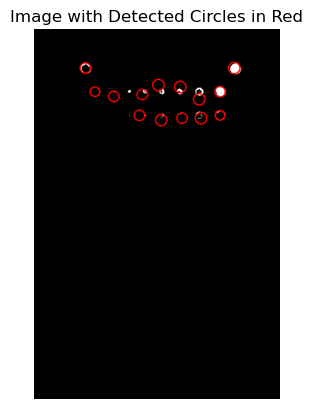

In [40]:

# Detect circles
circles = cv2.HoughCircles(thresholded_image, cv2.HOUGH_GRADIENT, dp=5, minDist=40, param1=50, param2=5, minRadius=9, maxRadius=15)

# Convert segmented_image to color for visualization
closed_image_color = cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2BGR)

# Draw circles on the image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(closed_image_color, (x, y), r, (0, 0, 255), 2)  # Red color in BGR format

# Convert image to RGB for displaying with Matplotlib
closed_image_color_rgb = cv2.cvtColor(closed_image_color, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(closed_image_color_rgb)
plt.title('Image with Detected Circles in Red')
plt.axis('off')  # Hide axis
plt.show()

## image segmentation with

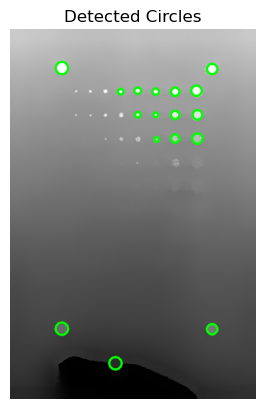

In [41]:
gray_img =  cv2.cvtColor(segmented_image_8, cv2.COLOR_BGR2GRAY)

# Check if image is loaded properly
if image is None:
    raise Exception("Error loading image")

# Apply Gaussian blur
blurred_gray_img = cv2.GaussianBlur(gray_img, (9, 9), 2)

# Detect circles using Hough Transform
circles = cv2.HoughCircles(blurred_gray_img, cv2.HOUGH_GRADIENT, dp=1.8, minDist=10,
                           param1=70, param2=20, minRadius=1, maxRadius=20 )

# Convert the original grayscale gray_img to BGR for visualization
output_gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

circle_centers = []

# Draw the circles
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output_gray_img, (x, y), r, (0, 255, 0), 4)  # Draw in green
        circle_centers.append((x, y))

# Convert to RGB for displaying with Matplotlib
output_gray_img_rgb = cv2.cvtColor(output_gray_img, cv2.COLOR_BGR2RGB)

# Plotting the result
plt.imshow(output_gray_img_rgb)
plt.title('Detected Circles')
plt.axis('off')
plt.show()


Distances verticales entre les cercles consécutifs alignés verticalement: [51.0, 49.0, 50.0, 50.0]


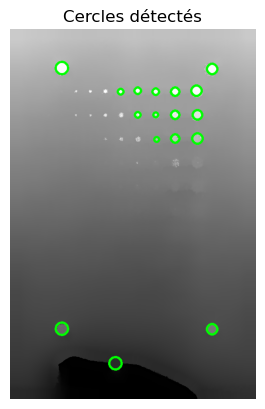

In [42]:
output_gray_img_rgb_ver = output_gray_img
# Trier les cercles par leur coordonnée x
circle_centers.sort(key=lambda coords: coords[0])

# Filtrer et calculer les distances entre les cercles alignés verticalement
vertical_distances = []
for i in range(len(circle_centers)-1):
    x1, y1 = circle_centers[i]
    x2, y2 = circle_centers[i+1]
    if abs(x1 - x2) <= 30:  # Seulement si les x sont proches à ±10 pixels
        distance = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
        if (49<=distance<=51):
            vertical_distances.append(distance)

print("Distances verticales entre les cercles consécutifs alignés verticalement:", vertical_distances)

# Convertir en RGB pour l'affichage avec Matplotlib
output_gray_img_rgb_ver = cv2.cvtColor(output_gray_img, cv2.COLOR_BGR2RGB)

# Afficher le résultat
plt.imshow(output_gray_img_rgb_ver)
plt.title('Cercles détectés')
plt.axis('off')
plt.show()

In [43]:
print(circles)

[[426 634  11]
 [348 132   9]
 [109  82  13]
 [395 231  11]
 [426  84  11]
 [393 130  11]
 [395 181  10]
 [348 231   9]
 [348 181   9]
 [109 633  13]
 [307 132   7]
 [269 130   7]
 [269 181   6]
 [309 233   5]
 [222 706  13]
 [233 132   6]
 [307 181   5]]


Distances horizontales entre les cercles consécutifs alignés horizontalement: [41.0, 38.0, 41.0, 47.0, 47.0]


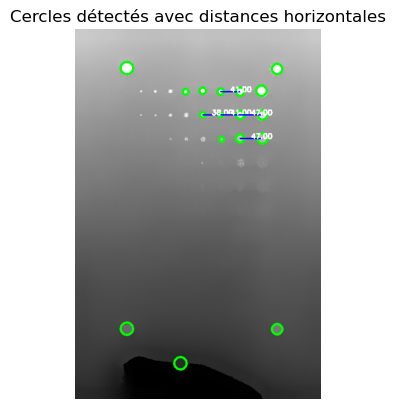

In [44]:
output_gray_img_rgb_hor = output_gray_img
# Trier les cercles par leur coordonnée y
circle_centers.sort(key=lambda coords: coords[1])

# Filtrer et calculer les distances entre les cercles alignés horizontalement
horizontal_distances = []
for i in range(len(circle_centers)-1):
    x1, y1 = circle_centers[i]

    x2, y2 = circle_centers[i+1]
    if abs(y1 - y2) <= 10:  # Seulement si les y sont proches à ±30 pixels
        distance = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
        if (0 <= distance <= 51):
            horizontal_distances.append(distance)
            # Dessiner une ligne entre les cercles
            cv2.line(output_gray_img_rgb_hor, (x1, y1), (x2, y2), (255, 0, 0), 2)
            midpoint = ((x1 + x2) // 2, (y1 + y2) // 2)
            # Afficher la distance sur la ligne
            cv2.putText(output_gray_img_rgb_hor, f"{distance:.2f}", midpoint, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

print("Distances horizontales entre les cercles consécutifs alignés horizontalement:", horizontal_distances)

# Convertir en RGB pour l'affichage avec Matplotlib
output_gray_img_rgb_hor_rgb = cv2.cvtColor(output_gray_img_rgb_hor, cv2.COLOR_BGR2RGB)

# Afficher le résultat
plt.imshow(output_gray_img_rgb_hor_rgb)
plt.title('Cercles détectés avec distances horizontales')
plt.axis('off')
plt.show()